In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

true_path = '/content/drive/MyDrive/gossipcop_real.csv'
fake_path = '/content/drive/MyDrive/gossipcop_fake.csv'

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

true_df['label'] = 1
fake_df['label'] = 0
df = pd.concat([true_df, fake_df])
df.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,news_url,title,tweet_ids,label
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...,1
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...,1
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...,1
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...,1
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...,1


In [2]:
print(df.shape)
df.isna().sum()

(22140, 5)


id              0
news_url      269
title           0
tweet_ids    1246
label           0
dtype: int64

,title,label
0,Selena Gomez-Justin Bieber Dating History: The...,0
1,Selena Gomez finally confirms reunion with Jus...,1
2,Ariana Grande Cancels Vietnam Concert Due to '...,1
3,'Game of Thrones' quiz: How well do you know y...,1
4,Miss America CEO Sam Haskell resigns with othe...,1
...,...,...
22135,Kim Kardashian's Tweet About Kylie Jenner's 'F...,0
22136,'Teen Wolf': MTV Readying New Take on the Fran...,1
22137,Nicole Kidman and more react to Golden Globe n...,1
22138,Star-Studded 2017 iHeartRadio Jingle Ball Tour...,1


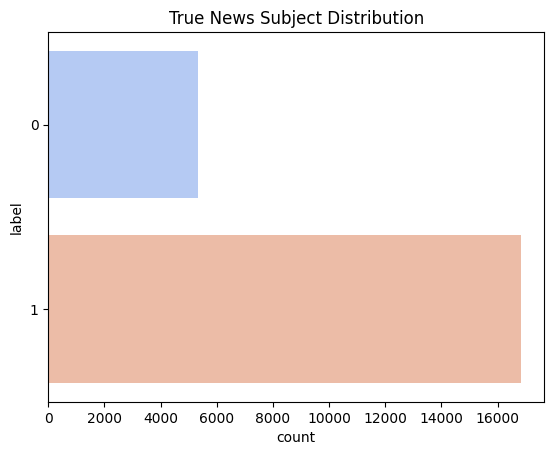

In [3]:
from sklearn.utils import shuffle

df = df[~df['title'].isna()][['title','label']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="label", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22140 entries, 0 to 22139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   22140 non-null  object
 1   label   22140 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 346.1+ KB


In [5]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20743 entries, 0 to 22139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20743 non-null  object
 1   label   20743 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 486.2+ KB


In [6]:
train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac = 0.875)
val_df = train_val_df.drop(train_df.index)

# Reset Index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)

trainset size: (14520, 2)
valset size: (2074, 2)
testset size: (4149, 2)


In [7]:
from sklearn.utils import resample
def upsample_data(df):
    df_majority = df[df.label == 0]
    df_minority = df[df.label == 1]
    if len(df_majority) >= len(df_minority):
      df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
      df_upsampled = pd.concat([df_majority, df_minority_upsampled])
      df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
    else:
      df_majority_upsampled = resample(df_majority, replace=True, n_samples=len(df_minority), random_state=42)
      df_upsampled = pd.concat([df_minority, df_majority_upsampled])
      df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)
    return df_upsampled

train_df= upsample_data(train_df)
val_df= upsample_data(val_df)

In [8]:
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

1    11135
0    11135
Name: label, dtype: int64
0    1584
1    1584
Name: label, dtype: int64
1    3195
0     954
Name: label, dtype: int64


In [9]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

In [10]:
!pip install transformers
import torch
from transformers import BertTokenizer
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 22270
valset size: 3168
testset size:  4149


In [12]:
sample_idx = 0

statement, label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
Radio Disney Music Awards 2018: Complete List of Nominations

tokens: 
['[CLS]', 'radio', 'disney', 'music', 'awards', '2018', ':', 'complete', 'list', 'of', 'nominations', '[SEP]']

label: 1

--------------------

tokens_tensor: 
tensor([ 101, 2557, 6373, 2189, 2982, 2760, 1024, 3143, 2862, 1997, 9930,  102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor: 
1




In [13]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [14]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

In [15]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

In [16]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
NUM_EPOCHS = 3
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

end_time = time.time()
training_time = end_time - start_time

device: cuda:0


  0%|          | 0/1392 [00:00<?, ?it/s]

  0%|          | 0/1392 [00:00<?, ?it/s]

  0%|          | 0/1392 [00:00<?, ?it/s]

In [17]:
torch.save(model, './best_model.pth')

BERT Model Accuracy :  0.8274282959749337
Precision :  0.9094813346547737
Recall :  0.8616588419405321
F1 :  0.8849244615879137
G-mean: 0.7836965654028851
Training time:  213.64393091201782
Inference time:  5.370302677154541
              precision    recall  f1-score   support

           0       0.61      0.71      0.66       954
           1       0.91      0.86      0.88      3195

    accuracy                           0.83      4149
   macro avg       0.76      0.79      0.77      4149
weighted avg       0.84      0.83      0.83      4149



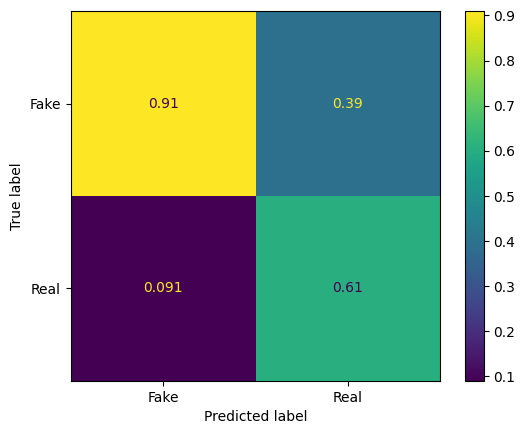

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score
true=[]
predictions=[]
start_time = time.time()
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

end_time = time.time()
inference_time = end_time - start_time
cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

accuracy = accuracy_score(true, predictions)

g_mean = geometric_mean_score(true, predictions)
print("BERT Model Accuracy : ", accuracy)
print("Precision : ", precision_score(true, predictions))
print("Recall : ", recall_score(true, predictions))
print("F1 : ", f1_score(true, predictions))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(true, predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()